In [19]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [20]:
for dirname, _, filenames in os.walk(os.path.join('..','extraction','raw_data')):
    for filename in filenames:
        print(os.path.join(dirname, filename))

..\extraction\raw_data\teams_data.csv
..\extraction\raw_data\day4\attacking_data.csv
..\extraction\raw_data\day4\attempts_data.csv
..\extraction\raw_data\day4\defending_data.csv
..\extraction\raw_data\day4\disciplinary_data.csv
..\extraction\raw_data\day4\distribution_data.csv
..\extraction\raw_data\day4\goalkeeping_data.csv
..\extraction\raw_data\day4\goals_data.csv
..\extraction\raw_data\day4\key_stats_data.csv
..\extraction\raw_data\day4\players_data.csv


In [21]:
players_df = pd.read_csv('../extraction/raw_data/day4/players_data.csv')
disciplinary_df = pd.read_csv('../extraction/raw_data/day4/disciplinary_data.csv')
attempts_df = pd.read_csv('../extraction/raw_data/day4/attempts_data.csv')
distribution_df = pd.read_csv('../extraction/raw_data/day4/distribution_data.csv')
key_stats_df = pd.read_csv('../extraction/raw_data/day4/key_stats_data.csv')
attacking_df = pd.read_csv('../extraction/raw_data/day4/attacking_data.csv')
goals_df = pd.read_csv('../extraction/raw_data/day4/goals_data.csv')
goalkeeping_df = pd.read_csv('../extraction/raw_data/day4/goalkeeping_data.csv')
defending_df = pd.read_csv('../extraction/raw_data/day4/defending_data.csv')

## Feature Selection

In [22]:
# Selecting the offensive features 
goals = goals_df[['id_player','goals']].copy()
top_speed = key_stats_df[['id_player','top_speed']].copy()
assists_dribbles = attacking_df[['id_player','assists','dribbles']].copy()
attempts_on_target = attempts_df[['id_player','attempts_on_target']].copy()

# Merging all dataframes with offensive features
merged_df = pd.merge(goals, top_speed, on='id_player', how='inner')
merged_df = pd.merge(merged_df, assists_dribbles, on='id_player', how='inner')
merged_df = pd.merge(merged_df, attempts_on_target, on='id_player', how='inner')
merged_df

,id_player,goals,top_speed,assists,dribbles,attempts_on_target
0,250112880,5.0,33.37,3.0,7.0,5.0
1,250139445,3.0,32.10,0.0,15.0,6.0
2,250121533,4.0,35.47,0.0,34.0,10.0
3,250159544,3.0,33.04,0.0,7.0,3.0
4,250091187,3.0,31.92,0.0,2.0,4.0
...,...,...,...,...,...,...
903,250011071,NaN,NaN,NaN,NaN,NaN
904,250000104,NaN,NaN,NaN,NaN,NaN
905,108501,NaN,NaN,NaN,NaN,NaN
906,103827,NaN,NaN,NaN,NaN,NaN


## Exploration and Data Preprocessing

In [23]:
# Descriptive statistics
merged_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id_player,908.0,2.414979e+08,4.522600e+07,69178.00,2.500805e+08,2.501215e+08,2.501668e+08,2.502042e+08
goals,727.0,2.833563e-01,7.154615e-01,0.00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00
top_speed,727.0,3.121792e+01,2.788519e+00,19.51,3.022500e+01,3.181000e+01,3.302000e+01,3.655000e+01
assists,727.0,2.173315e-01,5.500584e-01,0.00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
dribbles,727.0,2.795048e+00,4.318016e+00,0.00,0.000000e+00,1.000000e+00,3.500000e+00,3.400000e+01
attempts_on_target,727.0,9.284732e-01,1.571212e+00,0.00,0.000000e+00,0.000000e+00,1.000000e+00,1.200000e+01


In [24]:
# Check for missing values
merged_df.isnull().sum()

id_player               0
goals                 181
top_speed             181
assists               181
dribbles              181
attempts_on_target    181
dtype: int64

In [25]:
# Drop NaN values
offensive_df = merged_df.dropna()

In [26]:
# Changet data type
offensive_df['goals'] = offensive_df['goals'].astype(int)
offensive_df['assists'] = offensive_df['assists'].astype(int)
offensive_df['dribbles'] = offensive_df['dribbles'].astype(int)
offensive_df['attempts_on_target'] = offensive_df['attempts_on_target'].astype(int)

In [27]:
# Check for duplicates
offensive_df.duplicated().sum()

np.int64(0)

## Feature Scaling

In [28]:
# Create the scalers
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

df_scaled = offensive_df.set_index('id_player')

# Apply scaling
df_scaled['goals'] = min_max_scaler.fit_transform(offensive_df[['goals']])
df_scaled['assists'] = min_max_scaler.fit_transform(offensive_df[['assists']])
df_scaled['attempts_on_target'] = min_max_scaler.fit_transform(offensive_df[['attempts_on_target']])
df_scaled['top_speed'] = standard_scaler.fit_transform(offensive_df[['top_speed']])
df_scaled['dribbles'] = standard_scaler.fit_transform(offensive_df[['dribbles']])

df_scaled

,goals,top_speed,assists,dribbles,attempts_on_target
id_player,,,,,
250112880,1.0,0.772295,0.75,0.974486,0.416667
250139445,0.6,0.316542,0.00,2.828464,0.500000
250121533,0.8,1.525901,0.00,7.231662,0.833333
250159544,0.6,0.653871,0.00,0.974486,0.250000
250091187,0.6,0.251947,0.00,-0.184250,0.333333
...,...,...,...,...,...
250007631,0.0,-2.547162,0.00,-0.647745,0.000000
250004986,0.0,-1.624891,0.00,-0.647745,0.000000
1905643,0.0,0.144289,0.00,0.279244,0.083333


## Determine the Optimal Number of Clusters

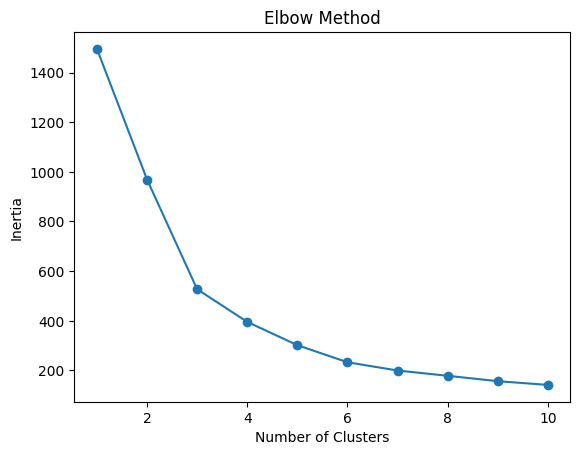

In [29]:
# Elbow method to determine the optimal number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow graph
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


## Apply Clustering Algorithm (K-Means)

In [30]:
# Apply KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')  # Change the number of clusters based on the elbow method
offensive_df['cluster'] = kmeans.fit_predict(df_scaled)

# Display the first results with cluster labels
offensive_df.head()

,id_player,goals,top_speed,assists,dribbles,attempts_on_target,cluster
0,250112880,5,33.37,3,7,5,2
1,250139445,3,32.10,0,15,6,2
2,250121533,4,35.47,0,34,10,2
3,250159544,3,33.04,0,7,3,1
4,250091187,3,31.92,0,2,4,1


## Visualize the clusters

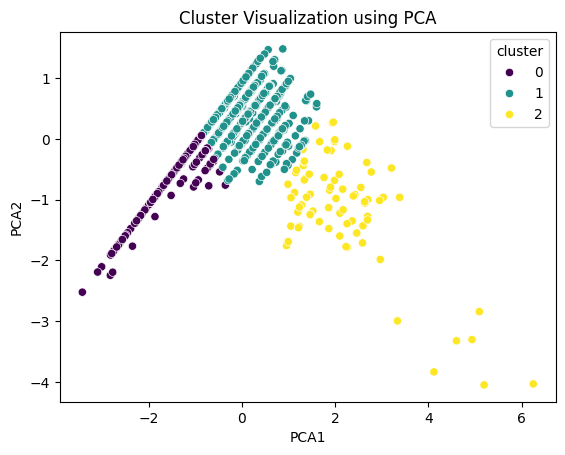

In [31]:
# Reduce dimensionality with PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

# Create a DataFrame with PCA results
df_pca = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
df_pca['cluster'] = offensive_df['cluster']

# Plot the clusters
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', data=df_pca, palette='viridis')
plt.title('Cluster Visualization using PCA')
plt.show()


In [32]:
# Analyze each cluster
df_clustered = offensive_df.groupby('cluster').mean()

# Display the average characteristics of each cluster
df_clustered.drop('id_player', axis=1)


,goals,top_speed,assists,dribbles,attempts_on_target
cluster,,,,,
0,0.034014,26.809660,0.040816,0.353741,0.22449
1,0.286000,32.201920,0.204000,1.918000,0.89000
2,0.725000,33.168125,0.625000,12.762500,2.46250


In [33]:
# Merge 'player_name' column 
offensive_df = offensive_df.merge(players_df[['id_player', 'player_name']], on='id_player', how='inner')
offensive_df.set_index('id_player', inplace=True)
offensive_df

,goals,top_speed,assists,dribbles,attempts_on_target,cluster,player_name
id_player,,,,,,,
250112880,5,33.37,3,7,5,2,Raphinha
250139445,3,32.10,0,15,6,2,Florian Wirtz
250121533,4,35.47,0,34,10,2,Vinícius Júnior
250159544,3,33.04,0,7,3,1,Antoni Milambo
250091187,3,31.92,0,2,4,1,Sandro Kulenović
...,...,...,...,...,...,...,...
250007631,0,24.12,0,0,0,0,Marc-André ter Stegen
250004986,0,26.69,0,0,0,0,Lukáš Pauschek
1905643,0,31.62,0,4,1,1,Juraj Kucka


In [34]:
offensive_df[offensive_df["cluster"]==0]

,goals,top_speed,assists,dribbles,attempts_on_target,cluster,player_name
id_player,,,,,,,
250196588,1,29.48,1,1,3,0,Hugo Magnetti
250005335,1,27.85,0,0,3,0,İlkay Gündoğan
250197796,1,29.62,0,0,1,0,Juanpe
250081207,1,29.25,0,0,1,0,Donny van de Beek
250161142,1,28.97,0,0,1,0,Daouda Guindo
...,...,...,...,...,...,...,...
250010259,0,28.92,0,0,1,0,Kyle Walker
250007631,0,24.12,0,0,0,0,Marc-André ter Stegen
250004986,0,26.69,0,0,0,0,Lukáš Pauschek


In [35]:
offensive_df[offensive_df["cluster"]==1]

,goals,top_speed,assists,dribbles,attempts_on_target,cluster,player_name
id_player,,,,,,,
250159544,3,33.04,0,7,3,1,Antoni Milambo
250091187,3,31.92,0,2,4,1,Sandro Kulenović
250099180,3,32.25,1,1,6,1,Dušan Vlahović
250127347,3,35.14,0,5,5,1,Karim Adeyemi
250022829,2,31.44,0,0,2,1,Hakan Çalhanoğlu
...,...,...,...,...,...,...,...
250055216,0,32.06,0,1,0,1,Nemanja Radonjić
250052849,0,31.85,0,1,0,1,Mirko Ivanić
250027008,0,30.81,0,0,1,1,Nathan Aké


In [36]:
offensive_df[offensive_df["cluster"]==2]

,goals,top_speed,assists,dribbles,attempts_on_target,cluster,player_name
id_player,,,,,,,
250112880,5,33.37,3,7,5,2,Raphinha
250139445,3,32.10,0,15,6,2,Florian Wirtz
250121533,4,35.47,0,34,10,2,Vinícius Júnior
250160436,2,33.39,1,10,4,2,Maghnes Akliouche
250106148,2,35.94,1,16,3,2,Nicolas Kühn
...,...,...,...,...,...,...,...
250113142,0,33.17,1,13,1,2,Jérémy Doku
250106967,0,32.93,0,16,0,2,Bryan Gil
250102901,0,34.74,1,7,0,2,Mama Baldé
